In [1]:
# !pip install -q py-feat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.4/653.4 kB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 31.3 MB/s eta 0:00:00


load extracted val cp and ncp features and process

In [2]:
import pickle 

with open('/content/cp_features_val_dyadic.pkl', 'rb') as f:
    val_cp = pickle.load(f)

with open('/content/ncp_val.pkl', 'rb') as f:
    val_ncp = pickle.load(f)


with open('/content/is_val.pkl', 'rb') as f:
    scalars = pickle.load(f)


In [4]:
imp_s = {}
for f in scalars:
  cps = scalars[f]
  for (t,s) in cps:
    imp_s[(f,t)] = s



In [5]:
#for val_cp run concat_window used for training data as well
def get_dataset_features_1(cp,scalars):
  features = []
  print('change_points')
  for file_id in cp:
    for time_stamp in cp[file_id]:
      impact_scalar = scalars[(file_id, time_stamp)]
      i_s = ""
      if impact_scalar > 3:
        i_s = "high"
      elif impact_scalar < 3:
        i_s = "low"
      elif impact_scalar  ==  3:
        i_s = "three"
      else:
        i_s = "noncp"

      features.append(concat_window(cp[file_id][time_stamp],file_id,i_s,impact_scalar,'cp'))
  data = pd.concat(features)
  data = data.reset_index(drop=True)
  data = data.sample(frac = 1)
  return data 

In [6]:
#for val_cp run concat_window2 used for training data as well
def get_dataset_features_2(cp,scalars):
  features = []
  print('non change_points')
  for file_id in cp:
    for time_stamp in cp[file_id]:
      impact_scalar = scalars[(file_id, time_stamp)]
      i_s = ""
      if impact_scalar > 3:
        i_s = "high"
      elif impact_scalar < 3:
        i_s = "low"
      elif impact_scalar  ==  3:
        i_s = "three"
      else:
        i_s = "noncp"

      features.append(concat_window2(cp[file_id][time_stamp],file_id,i_s,impact_scalar,'cp'))


  data = pd.concat(features)
  data = data.reset_index(drop=True)
  data = data.sample(frac = 1)
  return data 

In [ ]:
new_val_1 = get_dataset_features_1(val_cp,imp_s)

In [ ]:
new_val_2 = get_dataset_features_2(val_cp,imp_s)

In [12]:
def concat_window_ncp(frames,file_id,time_stamp,num,label):
  df1 = frames[0].drop(['input', 'frame'], axis=1)
  df2 = frames[1].drop(['input', 'frame'], axis=1)
  diff1 = df1.diff().iloc[1:]
  diff1.columns = [str(col) + '_diff1' for col in diff1.columns]
  diff2 = df2.diff().iloc[1:]
  diff2.columns = [str(col) + '_diff2' for col in diff2.columns]
  diff = pd.concat([diff1, diff2], axis=1)
  diff['file_id'] = file_id
  diff['time'] = time_stamp
  diff['impact_scalar'] = "none"
  diff['label'] = label
  diff['impact_scalar_num'] = num
 
  return diff

In [30]:
def get_dataset_features_1_ncp(ncp):
  features = []
  print('change_points')
  for file_id in ncp:
    for frames in ncp[file_id]:
      span = ncp[file_id][frames]
      if len(span) == 2:
    
        time_stamp = list(frames)[0]
        impact_scalar = 0
      
        features.append(concat_window_ncp(span,file_id,time_stamp,impact_scalar,'ncp'))
  data = pd.concat(features)
  data = data.reset_index(drop=True)
  data = data.sample(frac = 1)
  return data 

In [21]:
def concat_window2_ncp(frames, file_id,time_stamp,num,label):
  df1 = pd.DataFrame(frames[0].drop(['input', 'frame'], axis=1))
  df2 = pd.DataFrame(frames[1].drop(['input', 'frame'], axis=1))
  diff1 = pd.DataFrame(columns=df1.columns)
  diff1.loc[len(diff1.index)] = [i1 * i2 for i1, i2 in zip(list(df1.iloc[0,:]), list(df1.iloc[1,:]))]
  diff1.columns = [str(col) + '_diff1' for col in diff1.columns]
  
  diff2 = pd.DataFrame(columns=df2.columns)
  diff2.loc[len(diff2)] = [i1 * i2 for i1, i2 in zip(list(df2.iloc[0,:]), list(df2.iloc[1,:]))]
  diff2.columns = [str(col) + '_diff2' for col in diff2.columns]
  
  diff = pd.concat([diff1, diff2], axis=1)
  diff['file_id'] = file_id
  diff['time'] = time_stamp
  diff['label'] = label
  diff['impact_scalar'] = "none"
  diff['impact_scalar_num'] = num
 
  return diff

In [41]:
def get_dataset_features_2_ncp(ncp):
  features = []
  print('change_points')
  for file_id in ncp:
    for frames in ncp[file_id]:
      span = ncp[file_id][frames]
      if len(span) == 2:
        time_stamp = list(frames)[0]
        impact_scalar = 0
        features.append(concat_window2_ncp(span,file_id,time_stamp,impact_scalar,'ncp'))
  data = pd.concat(features)
  data = data.reset_index(drop=True)
  data = data.sample(frac = 1)
  return data 

In [31]:
val_ncp_1 = get_dataset_features_1_ncp(val_ncp)

change_points


In [35]:
val_ncp_1 = val_ncp_1.dropna()
val_ncp_1.to_csv('/content/drive/MyDrive/research_2023_experiments /features1_new_val_ncp.csv',index = False)

In [ ]:
val_ncp_2 = get_dataset_features_2_ncp(val_ncp)
val_ncp_2 = val_ncp_2.dropna()
val_ncp_2.to_csv('/content/drive/MyDrive/research_2023_experiments /features2_new_val_ncp.csv',index = False)

In [43]:
val_1 = pd.concat([val_ncp_1, new_val_1])
val_1 = val_1.sample(frac = 1)
val_1 = val_1.reset_index(drop=True)

In [44]:
val_2 = pd.concat([val_ncp_2, new_val_2])
val_2 = val_2.sample(frac = 1)
val_2 = val_2.reset_index(drop=True)

In [45]:
val_1 = val_1.dropna()
val_2 = val_2.dropna()
val_1.to_csv('/content/drive/MyDrive/research_2023_experiments /features1_new_val.csv',index = False)
val_2.to_csv('/content/drive/MyDrive/research_2023_experiments /features2_new_val.csv',index = False)

In [116]:
#read in saved val csv files after features 1 and 2 are put together
import pandas as pd
val_1 = pd.read_csv('/content/drive/MyDrive/research_2023_experiments /features1_new_val.csv')
val_2 = pd.read_csv('/content/drive/MyDrive/research_2023_experiments /features2_new_val.csv')

Load in saved train features sets

In [12]:
import pickle 

with open('/content/drive/MyDrive/research_files/change_points_train_two.pkl', 'rb') as f:
    cp_train = pickle.load(f)

with open('/content/drive/MyDrive/research_files/nonchange_points_train_two.pkl', 'rb') as f:
    ncp_train = pickle.load(f)


In [34]:
#load in saved impact_scalars for train changepoints 
import pickle
with open('/content/train.pkl', 'rb') as f:
    train = pickle.load(f)


In [48]:
import pandas as pd

#given and list of three dfs concatenate the -5 and +5 dfs difference (list[0], list[2])
def concat_window(frames, file_id,i_s,num,label):
  time_stamp = frames[1]['time']
  df1 = frames[0].drop(['time', 'input', 'frame'], axis=1)
  df2 = frames[2].drop(['time', 'input', 'frame'], axis=1)
  diff1 = df1.diff().iloc[1:]
  diff1.columns = [str(col) + '_diff1' for col in diff1.columns]
  diff2 = df2.diff().iloc[1:]
  diff2.columns = [str(col) + '_diff2' for col in diff2.columns]
  diff = pd.concat([diff1, diff2], axis=1)
  diff['file_id'] = file_id
  diff['time'] = time_stamp
  diff['impact_scalar'] = i_s
  diff['label'] = label
  diff['impact_scalar_num'] = num
 
  return diff


In [9]:
import numpy as np 
def concat_window2(frames, file_id,i_s,num,label):
  time_stamp = frames[1]['time']
  df1 = pd.DataFrame(frames[0].drop(['time', 'input', 'frame'], axis=1))
  df2 = pd.DataFrame(frames[2].drop(['time', 'input', 'frame'], axis=1))
  diff1 = pd.DataFrame(columns=df1.columns)
  diff1.loc[len(diff1.index)] = [i1 * i2 for i1, i2 in zip(list(df1.iloc[0,:]), list(df1.iloc[1,:]))]
  diff1.columns = [str(col) + '_diff1' for col in diff1.columns]
  
  diff2 = pd.DataFrame(columns=df2.columns)
  diff2.loc[len(diff2)] = [i1 * i2 for i1, i2 in zip(list(df2.iloc[0,:]), list(df2.iloc[1,:]))]
  diff2.columns = [str(col) + '_diff2' for col in diff2.columns]
  
  diff = pd.concat([diff1, diff2], axis=1)
  diff['file_id'] = file_id
  diff['time'] = time_stamp
  diff['label'] = label
  diff['impact_scalar'] = i_s
  diff['impact_scalar_num'] = num
 
  return diff

In [39]:
def get_dataset_features_1(cp,ncp,scalars):
  features = []
  print('change_points')
  for file_id in cp:
    for time_stamp in cp[file_id]:
      impact_scalar = scalars[(file_id, time_stamp)]
      i_s = ""
      if impact_scalar > 3:
        i_s = "high"
      elif impact_scalar < 3:
        i_s = "low"
      elif impact_scalar  ==  3:
        i_s = "three"
      else:
        i_s = "noncp"

      features.append(concat_window(cp[file_id][time_stamp],file_id,i_s,impact_scalar,'cp'))

  print('non_change_points')
  for file_id in ncp:
    for time_stamp in ncp[file_id]:
      i_s = "noncp"
      features.append(concat_window(ncp[file_id][time_stamp],file_id ,i_s, 0,'ncp'))

  data = pd.concat(features)
  data = data.reset_index(drop=True)
  data = data.sample(frac = 1)
  return data 


def get_dataset_features_2(cp,ncp,scalars):
  features = []
  print('change_points')
  for file_id in cp:
    for time_stamp in cp[file_id]:
      impact_scalar = scalars[(file_id, time_stamp)]
      i_s = ""
      if impact_scalar > 3:
        i_s = "high"
      elif impact_scalar < 3:
        i_s = "low"
      elif impact_scalar  ==  3:
        i_s = "three"
      else:
        i_s = "noncp"

      features.append(concat_window2(cp[file_id][time_stamp],file_id,i_s,impact_scalar,'cp'))

  print('non_change_points')
  for file_id in ncp:
    for time_stamp in ncp[file_id]:
      i_s = "noncp"
      features.append(concat_window2(ncp[file_id][time_stamp],file_id ,i_s,0,'ncp'))

  data = pd.concat(features)
  data = data.reset_index(drop=True)
  data = data.sample(frac = 1)
  return data 




In [ ]:
data_train_features_1 = get_dataset_features_1(cp_train,ncp_train,train)
data_train_features_2 = get_dataset_features_2(cp_train,ncp_train,train)

data_train_features_1.to_csv('/content/drive/MyDrive/research_2023_experiments /features1_train.csv',index=False)
data_train_features_2.to_csv('/content/drive/MyDrive/research_2023_experiments /features2_train.csv',index=False)

load in already processed features (after running both val and train process can automatically load in csv's)

In [118]:
import pandas as pd 
#load in train features 1 and 2 (if already processed)
data_train_1 = pd.read_csv('/content/drive/MyDrive/research_2023_experiments /features1_train.csv')
data_train_1 = data_train_1.dropna()
data_train_2 = pd.read_csv('/content/drive/MyDrive/research_2023_experiments /features2_train.csv')
data_train_2 = data_train_2.dropna()

convert labels to numeric labels (0 for ncp and 1 for cp)

In [123]:
data_val_1 = val_1
data_val_2 = val_2

In [124]:
#factorize labels (binary)
def numeric_labels_bin(df):
  labels = pd.factorize(df['label'], sort=False)
  df['numerical_label'] = labels[0]
  df = df.dropna()
  return df 

data_features_1 = numeric_labels_bin(data_train_1)
data_features_2 = numeric_labels_bin(data_train_2)

val_features_1 = numeric_labels_bin(data_val_1)
val_features_2 = numeric_labels_bin(data_val_2)

In [50]:
#labels 0,1,2,3
def numeric_labels_multi(df):
  labels = pd.factorize(df['impact_scalar'], sort=False)
  df['impact_scalar'] = labels[0]
  df = df.dropna()
  return df

now run models

In [7]:
#this is bc pandas raises a warning when trying to set a new column on a copy of a pandas as df but
#doesn't have any computational effect 
pd.options.mode.chained_assignment = None

In [18]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
def log_reg_bin(df_train,df_val,name):

  output = df_val[['time','file_id','impact_scalar_num']]
  output['type'] = 'video'
  X = df_train.drop(['label','numerical_label','file_id','time','impact_scalar','impact_scalar_num'],axis=1)
  X_val = df_val.drop(['label','numerical_label','file_id','time','impact_scalar','impact_scalar_num'],axis=1)
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X)
  X_test = scaler.transform(X_val)

  y_train = df_train.numerical_label
  y_test = df_val.numerical_label
 

  log_reg = LogisticRegression(solver='liblinear')
  log_reg.fit(X_train, y_train)
  y_pred = log_reg.predict(X_test)

  print("f1 score " + str(f1_score(y_test, y_pred)))
  print("accuracy score " + str(accuracy_score(y_test, y_pred)))


  proba = log_reg.predict_proba(X_test)
  positive_proba = proba[:, 1]
  negative_proba = proba[:, 0] 
  output['preds'] = y_pred
  output['true'] = y_test
  output['llr'] = np.log(positive_proba)-np.log(negative_proba)
  output.to_csv(name, index = False)
  



In [125]:
log_reg_bin(data_train_1,val_features_1, '/content/drive/MyDrive/research_2023_experiments /all_features1_log_bin.csv')

f1 score 0.020471740097908322
accuracy score 0.3939977973568282


In [127]:
log_reg_bin(data_train_2,val_features_2,'/content/drive/MyDrive/research_2023_experiments /all_features2_log_bin.csv')

f1 score 0.011650485436893204
accuracy score 0.43942731277533037


multiclass impact scalar preds 

In [153]:
def relabel(arr):
  new_labels = []
  for label in arr:
    if label == 'none' or label == 'noncp':
      new_labels.append(0)
    else:
      new_labels.append(1)
  return new_labels



In [154]:
from sklearn import linear_model
import numpy as np
def numeric_labels_multi(df):
  labels = {'high': '2', 'low': '1', 'three': '3', 'noncp': '0'}
  df['numerical_label'] = df['impact_scalar'].map(labels)
  return df 

  
def log_reg_multi(df_train,df_val,name):
  output = df_val[['time','file_id','impact_scalar_num']]
  output['type'] = 'video'

  X = df_train.drop(['label','numerical_label','file_id','time','impact_scalar','impact_scalar_num'],axis=1)
  X_val = df_val.drop(['label','numerical_label','file_id','time','impact_scalar','impact_scalar_num'],axis=1)
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X)
  X_test = scaler.transform(X_val)

  y_train = df_train.impact_scalar
  y_test = df_val.impact_scalar
  reweigted_y_test = relabel(y_test)
  

  log_reg = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
  log_reg.fit(X_train, y_train)
  y_pred = log_reg.predict(X_test)
  reweigted_y_pred = relabel(y_pred)

  proba = log_reg.predict_proba(X_test)
  print( log_reg.classes_)
  pos = 1-proba[:, 2]
  log_neg = np.log(proba[:, 2]) 
  output['preds'] = reweigted_y_pred
  output['true'] = reweigted_y_test
  output['llr'] = np.log(pos)-log_neg
  output.to_csv(name, index = False)

  print("f1 score " + str(f1_score(reweigted_y_test, reweigted_y_pred)))
  print("accuracy score " + str(accuracy_score(reweigted_y_test, reweigted_y_pred)))


In [155]:
log_reg_multi(data_train_1,val_features_1,'/content/drive/MyDrive/research_2023_experiments /all_features1_multi.csv')

['high' 'low' 'noncp' 'three']
f1 score 0.022944550669216062
accuracy score 0.5779185022026432


In [156]:
log_reg_multi(data_train_2,val_features_2,'/content/drive/MyDrive/research_2023_experiments /all_features2_multi.csv')

['high' 'low' 'noncp' 'three']
f1 score 0.023679417122040074
accuracy score 0.7048458149779736


PCA on train to find the top features

In [36]:
from sklearn.decomposition import PCA
def pca(all_data,n):
# Instantiate the PCA object with n_components equal to the number of features
  X = all_data.drop(['label','numerical_label','file_id','time','impact_scalar'],axis=1)
  pca = PCA(n_components=len(X.columns))
  pca.fit(X)
  importance_scores = abs(pca.components_)
  total_scores = importance_scores.sum(axis=0)
  top_features_idx = total_scores.argsort()[::-1][:n]
  top_features = X.columns[top_features_idx]
  return top_features



use pca and other means of feature sets and test for log reg classifiers

In [37]:
top_50_1 = pca(data_train_1,50)
top_50_2 = pca(data_train_2,50)
top_100_1 = pca(data_train_1,100)
top_100_2 = pca(data_train_2,100)
emotions = ['anger_diff1', 'disgust_diff1', 'fear_diff1', 'happiness_diff1', 'sadness_diff1', 'surprise_diff1', 'neutral_diff1','anger_diff2', 'disgust_diff2', 'fear_diff2', 'happiness_diff2', 'sadness_diff2', 'surprise_diff2', 'neutral_diff2']

In [38]:
top_200_1 = pca(data_train_1,200)
top_200_2 = pca(data_train_2,200)

In [39]:
from sklearn.linear_model import LogisticRegression

def importance(df_train, df_val):
  X = df_train.drop(['label','numerical_label','file_id','time','impact_scalar','impact_scalar_num'],axis=1)
  X_val = df_val.drop(['label','numerical_label','file_id','time','impact_scalar','impact_scalar_num'],axis=1)
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X)
  X_test = scaler.transform(X_val)

  y_train = df_train.numerical_label
  y_test = df_val.numerical_label
  model = LogisticRegression(solver='liblinear',max_iter=1000)

  model.fit(X_train, y_train)
  importances = pd.DataFrame(data={
      'Attribute': X.columns,
      'Importance': model.coef_[0]
  })
  importances = importances.sort_values(by='Importance', ascending=False)
  return importances

In [40]:
w_features = importance(data_train_1, data_val_1)

In [41]:
imp = w_features.head(50)

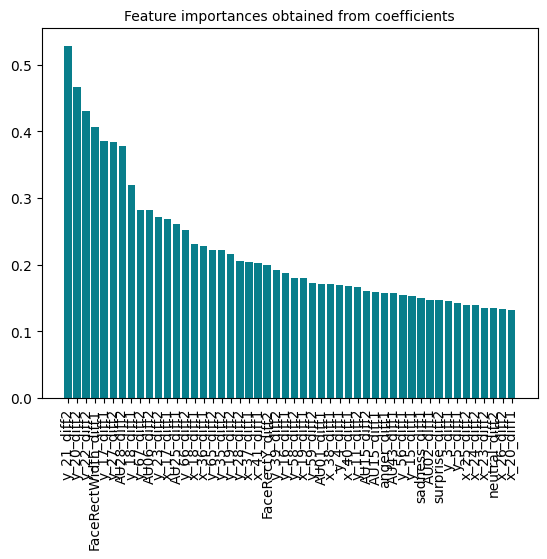

In [42]:
import matplotlib.pyplot as plt
plt.bar(x=imp['Attribute'], height=imp['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=10)
plt.xticks(rotation='vertical')
plt.show()

In [43]:
def log_reg_bin_features(df_train,df_val,name,features):
  output = df_val[['time','file_id','impact_scalar_num']]
  output['type'] = 'video'
  X = df_train[features]
  X_val = df_val[features]
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X)
  X_test = scaler.transform(X_val)

  y_train = df_train.numerical_label
  y_test = df_val.numerical_label

  log_reg = LogisticRegression(solver='liblinear')
  log_reg.fit(X_train, y_train)
  y_pred = log_reg.predict(X_test)

  print("f1 score " + str(f1_score(y_test, y_pred)))
  print("accuracy score " + str(accuracy_score(y_test, y_pred)))


  proba = log_reg.predict_proba(X_test)
  positive_proba = proba[:, 1]
  negative_proba = proba[:, 0] 
  output['preds'] = y_pred
  output['true'] = y_test
  output['llr'] = np.log(positive_proba)-np.log(negative_proba)
  output.to_csv(name, index = False)

In [44]:
log_reg_bin_features(data_train_1,data_val_1,'/content/drive/MyDrive/research_2023_experiments /all_features1_top100.csv',top_100_1)

f1 score 0.01715854495538778
accuracy score 0.21145374449339208


In [45]:
log_reg_bin_features(data_train_2,data_val_2,'/content/drive/MyDrive/research_2023_experiments /all_features2_top100.csv',top_100_2)

f1 score 0.011196641007697692
accuracy score 0.6109581497797357


In [46]:
log_reg_bin_features(data_train_1,data_val_1,'/content/drive/MyDrive/research_2023_experiments /all_features1_top200.csv',top_200_1)
log_reg_bin_features(data_train_2,data_val_2,'/content/drive/MyDrive/research_2023_experiments /all_features2_top200.csv',top_200_2)

f1 score 0.016949152542372885
accuracy score 0.23348017621145375
f1 score 0.010057471264367816
accuracy score 0.6205947136563876


In [47]:
log_reg_bin_features(data_train_1,data_val_1,'/content/drive/MyDrive/research_2023_experiments /all_features1_emotions.csv',emotions)
log_reg_bin_features(data_train_2,data_val_2,'/content/drive/MyDrive/research_2023_experiments /all_features2_emotions.csv',emotions)

f1 score 0.017686072218128224
accuracy score 0.2659691629955947
f1 score 0.011320754716981131
accuracy score 0.5671806167400881


train a mlp classifier 

In [48]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
def mlp(df_train,df_val,name):
  output = df_val[['time','file_id','impact_scalar_num']]
  output['type'] = 'video'
  X = df_train.drop(['label','numerical_label','file_id','time','impact_scalar','impact_scalar_num'],axis=1)
  X_val = df_val.drop(['label','numerical_label','file_id','time','impact_scalar','impact_scalar_num'],axis=1)
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X)
  X_test = scaler.transform(X_val)

  y_train = df_train.numerical_label
  y_test = df_val.numerical_label

  clf = MLPClassifier(random_state=1, max_iter=500).fit(X_train, y_train)
 
  y_pred =  clf.predict(X_test)

  print("f1 score " + str(f1_score(y_test, y_pred)))
  print("accuracy score " + str(accuracy_score(y_test, y_pred)))

  proba = clf.predict_proba(X_test)
  positive_proba = proba[:, 1]
  negative_proba = proba[:, 0] 
  output['preds'] = y_pred
  output['true'] = y_test
  output['llr'] = np.log(positive_proba)-np.log(negative_proba)
  output.to_csv(name, index = False)


In [49]:
mlp(data_train_1, data_val_1,'/content/drive/MyDrive/research_2023_experiments /all_features1_mlp.csv')

f1 score 0.022645393721049924
accuracy score 0.477147577092511


In [50]:
mlp(data_train_2, data_val_2,'/content/drive/MyDrive/research_2023_experiments /all_features2_mlp.csv')

f1 score 0.014367816091954025
accuracy score 0.43337004405286345


In [51]:
def mlp_select(df_train,df_val,features,name):
  output = df_val[['time','file_id','impact_scalar_num']]
  output['type'] = 'video'
  X = df_train[features]
  X_val = df_val[features]
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X)
  X_test = scaler.transform(X_val)

  y_train = df_train.numerical_label
  y_test = df_val.numerical_label

  clf = MLPClassifier(random_state=1, max_iter=10000).fit(X_train, y_train)
 
  y_pred =  clf.predict(X_test)

  print("f1 score " + str(f1_score(y_test, y_pred)))
  print("accuracy score " + str(accuracy_score(y_test, y_pred)))

  proba = clf.predict_proba(X_test)
  positive_proba = proba[:, 1]
  negative_proba = proba[:, 0] 
  output['preds'] = y_pred
  output['true'] = y_test
  output['llr'] = np.log(positive_proba)-np.log(negative_proba)
  output.to_csv(name, index = False)

In [56]:
mlp_select(data_train_1,data_val_1,emotions,'/content/drive/MyDrive/research_2023_experiments /all_features1_mlp_emotions.csv')

f1 score 0.020568663036902603
accuracy score 0.5542400881057269


In [57]:
mlp_select(data_train_2,data_val_2,emotions,'/content/drive/MyDrive/research_2023_experiments /all_features2_mlp_emotions.csv')

f1 score 0.014484679665738161
accuracy score 0.5129405286343612
